In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [94]:
# GET DATASETS
df_features = pd.read_csv('csv/Features.csv')
df_streams = pd.read_csv('csv/Streams.csv')

In [95]:
# CONCAT DATASETS

df_final=pd.concat([df_features,df_streams],axis=1,join='inner')

# DROP USELESS COLUMNS

df_final=df_final.drop(columns=["Release Date","name","id", "duration","Artist"]).set_index("Song")
df_final

,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability,Streams (Billions)
Song,,,,,,,,,,,,
Blinding Lights,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,0.514,3.449
Shape of You,0.652,1,-3.183,0,0.0802,0.58100,0.000000,0.0931,0.931,95.977,0.825,3.398
Dance Monkey,0.588,6,-6.400,0,0.0924,0.69200,0.000104,0.1490,0.513,98.027,0.824,2.770
Someone You Loved,0.405,1,-5.679,1,0.0319,0.75100,0.000000,0.1050,0.446,109.891,0.501,2.680
Rockstar,0.520,5,-6.136,0,0.0712,0.12400,0.000070,0.1310,0.129,159.801,0.585,2.620
...,...,...,...,...,...,...,...,...,...,...,...,...
7 Years,0.473,10,-5.829,1,0.0514,0.28700,0.000000,0.3910,0.340,119.992,0.765,1.529
Yellow,0.661,11,-7.227,1,0.0281,0.00239,0.000121,0.2340,0.285,173.372,0.429,1.527
Sugar,0.816,0,-4.209,1,0.0465,0.12200,0.000000,0.3350,0.557,95.390,0.548,1.524


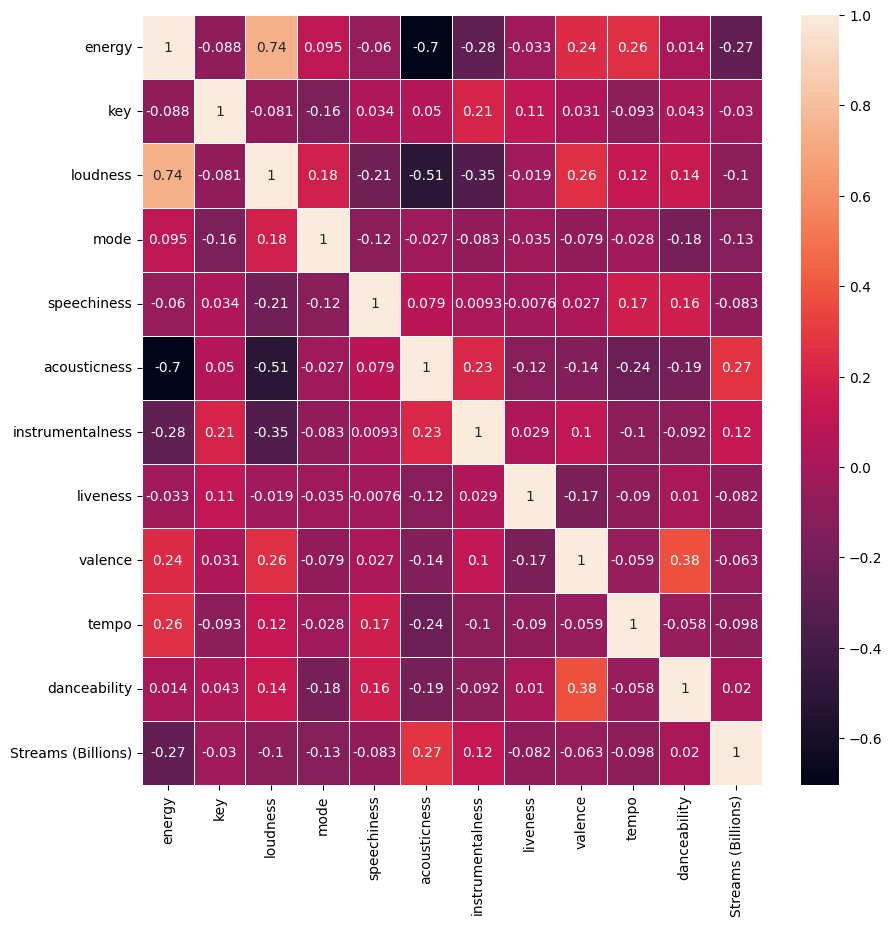

In [96]:
corr = df_final.corr()
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)
plt.show()

In [97]:

# Sélection des colonnes à utiliser pour le clustering
X = pd.DataFrame(df_final, columns=["energy", "loudness", "mode", "speechiness", "acousticness",
          "instrumentalness", "liveness", "valence", "tempo", "danceability"])


In [98]:
# Normaliser les données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [99]:
# Effectuer une analyse en composantes principales (PCA)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

In [100]:
# Convertir les données PCA en DataFrame
pca_df = pd.DataFrame(pca_data, columns=["Composante principale 1", "Composante principale 2"])

# Ajouter l'index original du DataFrame df
pca_df["Index original"] = df_final.index

# Afficher le DataFrame avec les données PCA et l'index original
print(pca_df)

    Composante principale 1  Composante principale 2     Index original
0                 -1.074424                 1.533078    Blinding Lights
1                 -0.651420                -2.255551       Shape of You
2                  1.000701                -1.384106       Dance Monkey
3                  1.604315                 1.184739  Someone You Loved
4                  0.308550                 0.710259           Rockstar
..                      ...                      ...                ...
95                 0.408228                 0.568094            7 Years
96                -0.392486                 2.190615             Yellow
97                -1.337160                 1.082181              Sugar
98                -1.812160                -0.560580          Despacito
99                 1.053855                 1.274417  Don't Stop Me Now

[100 rows x 3 columns]


In [101]:
# Paramètres à tester
min_samples_range = range(1, 10)
eps_range = np.arange(0.1, 1.0, 0.1)
results = []

In [102]:
# Boucle pour tester différents paramètres
for min_samples in min_samples_range:
    for eps in eps_range:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan_model.fit_predict(pca_data)
        n_clusters = len(set(dbscan_labels))
        results.append({'min_samples': min_samples, 'eps': eps, 'n_clusters': n_clusters})

# Création du DataFrame à partir de la liste de résultats
df_result = pd.DataFrame(results)
df_result

,min_samples,eps,n_clusters
0,1,0.1,89
1,1,0.2,73
2,1,0.3,57
3,1,0.4,42
4,1,0.5,27
...,...,...,...
76,9,0.5,2
77,9,0.6,3
78,9,0.7,3
79,9,0.8,2


In [103]:
# Créer un modèle DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(pca_data)

n_clusters = len(np.unique(clusters))
n_noise = np.sum(dbscan.labels_ != -1)
print(f"Nombre de clusters: {n_clusters}")
print("Le nombre de points avec bruit est : ", n_noise)

Nombre de clusters: 6
Le nombre de points avec bruit est :  55


In [104]:
# Calculer le score de silhouette
sil_score = silhouette_score(pca_data, clusters)

# Afficher le score de silhouette
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.03054178380629754


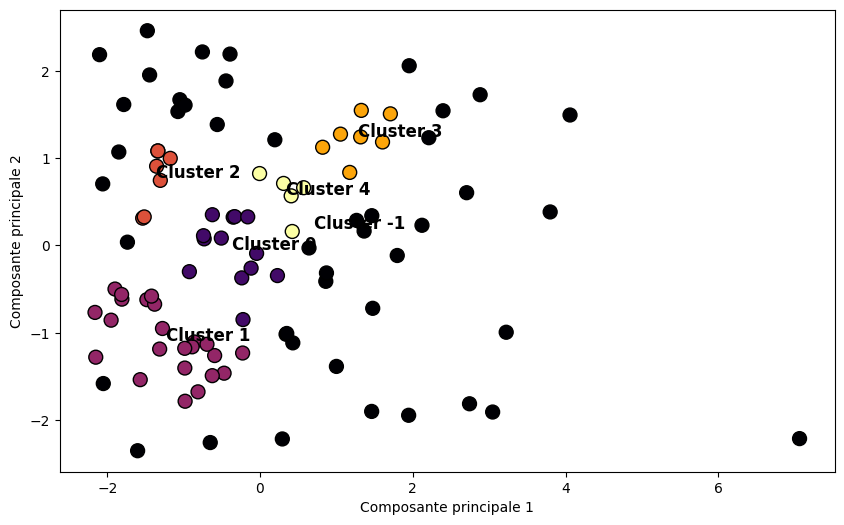

In [105]:
# Créer une figure pour visualiser les résultats de clustering
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='inferno', marker='o', s=100, edgecolor='k')
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")

# Afficher les numéros de cluster à côté des points
for i, txt in enumerate(np.unique(clusters)):
    cluster_center = np.mean(pca_data[clusters == txt], axis=0)
    plt.annotate(f"Cluster {txt}", (cluster_center[0], cluster_center[1]), fontsize=12, fontweight='bold')
    

# Ajouter des annotations avec les indices originaux des données
#for i in range(len(pca_data)):
#    plt.annotate(df.index[i], (pca_data[i, 0], pca_data[i, 1]), fontsize=6, xytext=(5, 2), textcoords='offset points')    

# Afficher le graphique
plt.show()

# Afficher les détails des différents clusters
#for i in np.unique(clusters):
#    print(f"\nCluster {2} :")
#    print(df.iloc[clusters == 2])
#    print()    